In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, KFold

import warnings
warnings.filterwarnings("ignore")
from src.constants import CLEANED_HOUSEHOLD_POWER_PATH, CLEANED_WEATHER_PATH, \
    HOUSEHOLD_WEATHER_MERGED_PATH

## Hourly distribution

In [3]:
df = pd.read_pickle(
    HOUSEHOLD_WEATHER_MERGED_PATH    
)

house_consumpion_columns = [
    'global_active_power', 
    'global_reactive_power', 
    'voltage',
    'global_intensity', 
    'sub_metering_1', 
    'sub_metering_2',
    'sub_metering_3'
]

df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0


In [4]:
df.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_1', 'sub_metering_2',
       'sub_metering_3', 'numer_sta', 'pmer', 'tend', 'cod_tend', 'dd', 'ff',
       't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm',
       'ch', 'pres', 'rafper', 'per', 'ssfrai', 'perssfrai', 'rr1', 'rr3',
       'phenspe1', 'phenspe2', 'phenspe3', 'nnuage1', 'ctype1', 'hnuage1',
       'Nom', 'Latitude', 'Longitude', 'Altitude'],
      dtype='object')

## Train test split

In [5]:
train_df = df.loc[:'31-12-2009']
test_df = df.loc['2010']


### Selecting columns

In [6]:
train_df.rolling(60, closed = 'left').mean()['global_active_power']

date
2007-01-01 00:00:00         NaN
2007-01-01 00:01:00         NaN
2007-01-01 00:02:00         NaN
2007-01-01 00:03:00         NaN
2007-01-01 00:04:00         NaN
                         ...   
2009-12-31 23:55:00    1.679067
2009-12-31 23:56:00    1.678633
2009-12-31 23:57:00    1.681633
2009-12-31 23:58:00    1.684567
2009-12-31 23:59:00    1.687667
Name: global_active_power, Length: 1578240, dtype: float64

In [7]:
train_df['last_hour_active_power'] = train_df.rolling(60, closed = 'left')\
    .mean()['global_active_power']

In [8]:

corr = train_df.corr()

In [9]:
abs(corr.loc['global_active_power']).sort_values().dropna().tail(10)

tend                      0.078283
td                        0.087960
global_reactive_power     0.230821
sub_metering_2            0.334389
sub_metering_1            0.346253
voltage                   0.383935
sub_metering_3            0.669907
last_hour_active_power    0.783796
global_intensity          0.997872
global_active_power       1.000000
Name: global_active_power, dtype: float64

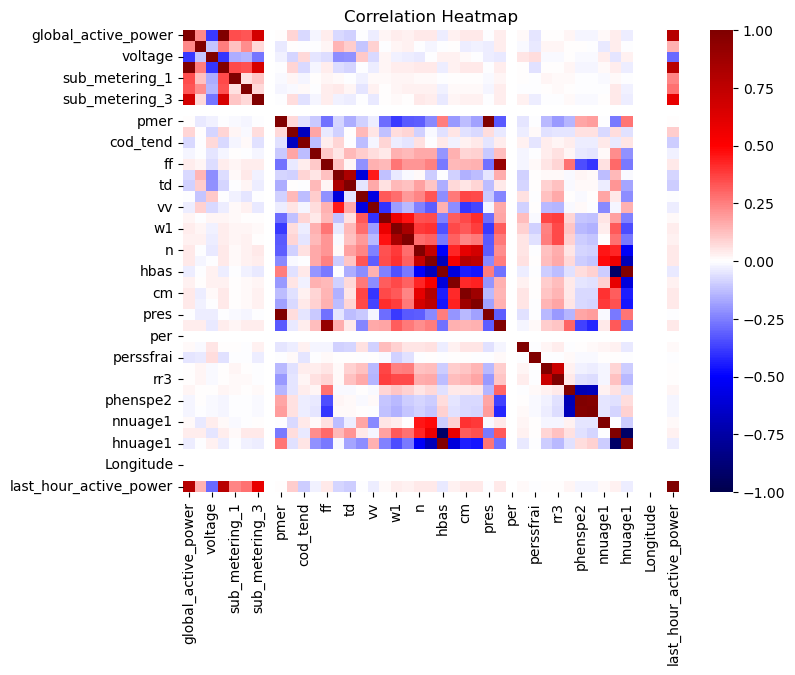

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [11]:
train_df

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude,last_hour_active_power
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0,NaN
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0,NaN
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0,NaN
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0,NaN
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 23:55:00,1.746,0.158,239.95,7.2,0.0,0.0,18.0,7149.0,99540.0,10.0,...,1110.0,3100.0,4.0,7.0,90.0,ORLY,48.716833,2.384333,89.0,1.679067
2009-12-31 23:56:00,1.786,0.234,240.09,7.4,0.0,0.0,19.0,7149.0,99540.0,10.0,...,1110.0,3100.0,4.0,7.0,90.0,ORLY,48.716833,2.384333,89.0,1.678633
2009-12-31 23:57:00,1.784,0.232,239.99,7.4,0.0,0.0,18.0,7149.0,99540.0,10.0,...,1110.0,3100.0,4.0,7.0,90.0,ORLY,48.716833,2.384333,89.0,1.681633


## Selecting features

In [12]:
selected_columns = corr['global_active_power'].abs() > 3e-2
selected_columns[house_consumpion_columns] = False
selected_columns = selected_columns[selected_columns].index

selected_columns

Index(['tend', 'cod_tend', 'ff', 't', 'td', 'vv', 'w1', 'w2', 'n', 'nbas',
       'hbas', 'cm', 'ch', 'rafper', 'perssfrai', 'ctype1', 'hnuage1',
       'last_hour_active_power'],
      dtype='object')

## Optimization methods

### Choosing model- cross validation

In [18]:

train_df_total = train_df[selected_columns]\
    .dropna()

target = df['global_active_power']

intersection_idx = target.index.intersection(train_df_total.index)

target = target.reindex(index = intersection_idx)
train_df_total = train_df_total.reindex(index = intersection_idx)



In [27]:
from typing import List
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from IPython.display import clear_output

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [28]:

models : List[BaseEstimator]= [LinearRegression(), Lasso(), RandomForestRegressor()]
results = {type(x).__name__ : [] for x in models}
n_splits =10
splitter = splitter = KFold(n_splits)

for model in models:

    model_name : str = type(model).__name__
    
    # clear_output()
    print(f"Running model selection for {model_name}")

    splits = splitter.split(train_df_total)

    for idx_train, idx_val in tqdm(splits, total = n_splits):
        X_train = train_df_total.iloc[idx_train]
        y_train = target.iloc[idx_train]

        X_val = train_df_total.iloc[idx_val]
        y_val = target.iloc[idx_val]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        validation_score = r2_score(y_val, y_pred)

        results[model_name].append(validation_score)

Running model selection for LinearRegression


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


Running model selection for Lasso


 40%|████      | 4/10 [01:20<02:00, 20.10s/it]


KeyboardInterrupt: 

In [22]:
results

{'LinearRegression': [0.6688981737845836,
  0.572042397725967,
  0.6385897700641946,
  0.6495814155311757,
  0.5707110783983891,
  0.6173429571423004,
  0.63400629032347,
  0.5619457211708596,
  0.5481833323599962,
  0.592677914686807],
 'Lasso': [-0.002009216138923131,
  -0.01827855275466872,
  0.0022825306453188032,
  -0.019445730592723587,
  0.0027544958782239615,
  -0.041740403454049835,
  -0.01607794727298284,
  0.013660629513865263,
  -0.048349348766205,
  -0.012241858056760258],
 'RandomForestRegressor': []}

In [86]:
X_train.dropna(inplace=True)
y_train = y_train.reindex(index = X_train.index)

In [97]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)




RandomForestRegressor()

In [98]:
y_pred = regressor.predict(X_val)
y_pred = pd.Series(y_pred, index = y_val.index)

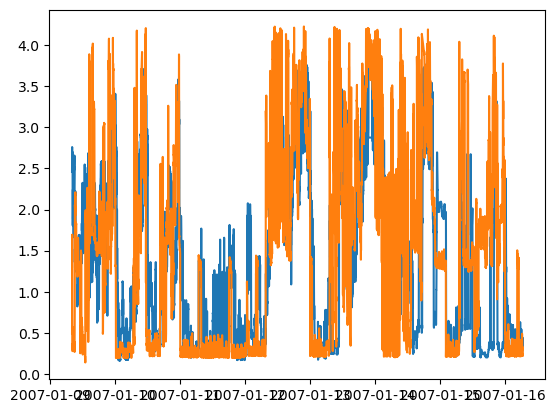

In [99]:
plt.plot(y_pred)
plt.plot(y_val)

In [100]:
from sklearn.metrics import r2_score
r2_score(y_val, y_pred)

0.3571521177248408